In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
import IPython.display as ipd
from itertools import cycle
from typing import TYPE_CHECKING
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import sys

sys.path.append("../src")
from Dataset import Dataset

if TYPE_CHECKING:
    plt.rcParams = {}
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
sns.set_theme(style="white", palette=None)

/opt/conda/envs/kaggle/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [95]:
import tensorflow as tf
from tensorflow import keras
import typing
from tensorflow import keras as k
from sklearn.model_selection import train_test_split

if typing.TYPE_CHECKING:
    print("emmm")
    from keras.api._v2 import keras as k

## 训练集
* 每个 sequence 对应 60 行数据。 要根据这 60 行数据做分类。
* 这 60 行是某个 subject 的 60 个 step。
* 每个 step 有 13 个传感器值。

## 试一下 lstm 的效果

In [34]:
ds = Dataset()
sensor_cols = [f"sensor{i:02d}" for i in range(13)]

In [16]:
ds.train.query("sequence == 0").head()

,sequence,subject,step,sensor00,sensor01,sensor02,sensor03,sensor04,sensor05,sensor06,sensor07,sensor08,sensor09,sensor10,sensor11,sensor12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


['sensor00',
 'sensor01',
 'sensor02',
 'sensor03',
 'sensor04',
 'sensor05',
 'sensor06',
 'sensor07',
 'sensor08',
 'sensor09',
 'sensor10',
 'sensor11',
 'sensor12']

In [36]:
def lstm_model(timesteps, feature):
    model = k.models.Sequential()
    model.add(k.layers.Input(shape=(timesteps, feature)))
    model.add(k.layers.LSTM(32))
    model.add(k.layers.Dense(1, activation="sigmoid"))
    return model

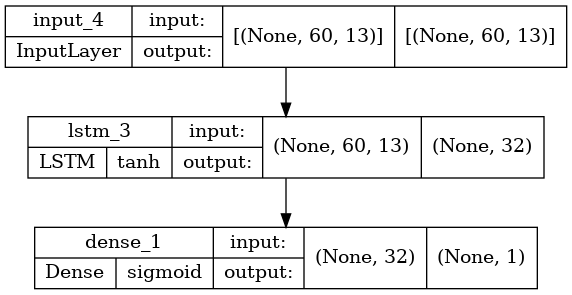

In [109]:
timesteps = ds.train.sequence.value_counts()[0]
feature = len(sensor_cols)
model = lstm_model(timesteps, feature)

k.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

model.compile(
    optimizer=k.optimizers.Adam(),
    loss=k.losses.BinaryCrossentropy(),
    metrics=[k.metrics.BinaryAccuracy()],
)


X = ds.train[sensor_cols].values.reshape(-1, timesteps, 13)
y = ds.label.state.values
xy = tf.data.Dataset.from_tensor_slices((X, y)).batch(32).shuffle(32 * 4)

L = int(len(xy) * 0.8)
model.fit(
    xy.take(L),
    validation_data=xy.skip(L),
    epochs=10,
)

Epoch 1/10
649/649 [==============================] - 4s 5ms/step - loss: 0.6774 - accuracy: 0.0000e+00 - val_loss: 0.6537 - val_accuracy: 0.0000e+00
Epoch 2/10
649/649 [==============================] - 3s 4ms/step - loss: 0.6412 - accuracy: 0.0000e+00 - val_loss: 0.6245 - val_accuracy: 0.0000e+00
Epoch 3/10
649/649 [==============================] - 3s 4ms/step - loss: 0.6139 - accuracy: 0.0000e+00 - val_loss: 0.6013 - val_accuracy: 0.0000e+00
Epoch 4/10
649/649 [==============================] - 3s 4ms/step - loss: 0.5861 - accuracy: 0.0000e+00 - val_loss: 0.5759 - val_accuracy: 0.0000e+00
Epoch 5/10
649/649 [==============================] - 3s 4ms/step - loss: 0.5567 - accuracy: 0.0000e+00 - val_loss: 0.5453 - val_accuracy: 0.0000e+00
Epoch 6/10
649/649 [==============================] - 3s 4ms/step - loss: 0.5354 - accuracy: 0.0000e+00 - val_loss: 0.5332 - val_accuracy: 0.0000e+00
Epoch 7/10
649/649 [==============================] - 3s 4ms/step - loss: 0.5134 - accuracy: 0.0000e

In [113]:
preds = model.predict(ds.test[sensor_cols].values.reshape(-1, timesteps, 13))

In [115]:
ds.submit_result(preds)